In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.applications import Xception
from keras import callbacks
from tensorflow import keras
import numpy as np

In [ ]:
n_classes = 38
batch_size = 32

In [ ]:
(train_ds, val_ds, test_ds), info = tfds.load('plant_village', split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], as_supervised=True, with_info=True)

In [ ]:
train_aug = tf.keras.Sequential([
	keras.layers.experimental.preprocessing.Resizing(299, 299),
	keras.layers.GaussianNoise(0.1),
	keras.layers.experimental.preprocessing.Rescaling(1./255),
 ])

train_ds = train_ds.shuffle(batch_size * 100).batch(batch_size).map(lambda x, y: (train_aug(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
   
val_ds = val_ds.batch(batch_size).map(lambda x, y: (train_aug(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
   
test_ds = test_ds.batch(batch_size).map(lambda x, y: (train_aug(x), y),
		 num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create callbacks
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2,
                              patience=5, 
                              verbose=1, 
                              mode="min",
                              min_delta=0.0001, 
                              cooldown=2, 
                              min_lr=1e-7)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/model_checkpoints',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
x = xception_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, activation='softmax')(x)

In [ ]:
xception_model = Model(inputs=xception_base.input, outputs=predictions, )

In [ ]:
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
xception_history = xception_model.fit(train_ds, batch_size=batch_size, epochs=1000, verbose=1, validation_data=val_ds, callbacks=[earlystopping, reduce_lr, model_checkpoint])

Epoch 1/1000
1188/1188 [==============================] - 197s 132ms/step - loss: 0.2158 - accuracy: 0.9357 - val_loss: 0.1098 - val_accuracy: 0.9659 - lr: 0.0010
Epoch 2/1000
1188/1188 [==============================] - 154s 129ms/step - loss: 0.0791 - accuracy: 0.9758 - val_loss: 0.0841 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 3/1000
1188/1188 [==============================] - 153s 128ms/step - loss: 0.0602 - accuracy: 0.9808 - val_loss: 0.4890 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 4/1000
1188/1188 [==============================] - 153s 128ms/step - loss: 0.0495 - accuracy: 0.9843 - val_loss: 0.5220 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 5/1000
1188/1188 [==============================] - 153s 128ms/step - loss: 0.0431 - accuracy: 0.9875 - val_loss: 0.1294 - val_accuracy: 0.9639 - lr: 0.0010
Epoch 6/1000
1188/1188 [==============================] - 154s 129ms/step - loss: 0.0395 - accuracy: 0.9875 - val_loss: 0.0784 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
1188/1188

In [ ]:
# Evaluate the CNN model
xception_score = xception_model.evaluate(test_ds)
print('Xception Accuracy:', xception_score)

170/170 [==============================] - 6s 34ms/step - loss: 0.0153 - accuracy: 0.9961
Xception Accuracy: [0.015345466323196888, 0.9961326122283936]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


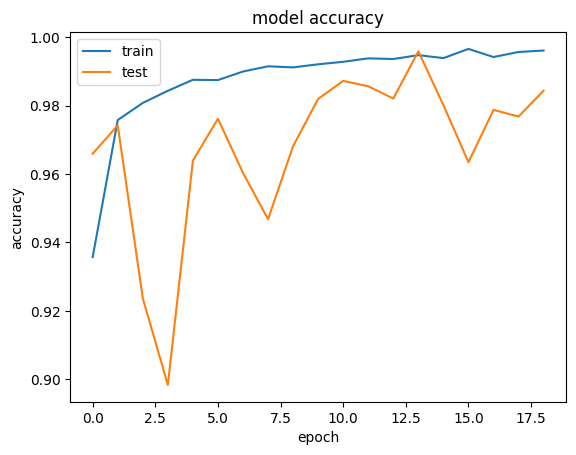

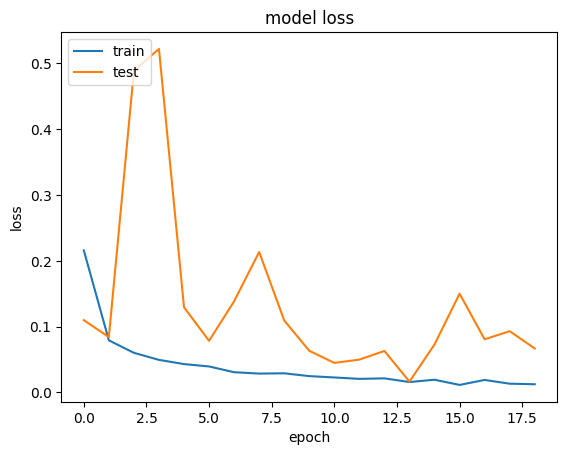

In [ ]:
import matplotlib.pyplot as plt

print(xception_history.history.keys())
# summarize history for accuracy
plt.plot(xception_history.history['accuracy'])
plt.plot(xception_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
xception_model.save('model.h5')